<a href="https://colab.research.google.com/github/ming80302/Innovator/blob/main/case_study_innovator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Innovator project case studies
Feb 2021 event (February 11–17, 2021 North American winter storm):
 - Daily Tmax
 - Daily Tmin
 - Daily precip tot
 - Daily (precip.and.Tmin<0) -> Ice
 - Number of days with Tmin<0 for the event
 - Lowest T over the event
June 2021 heatwave (June 27 - June 30)
 - Daily Tmax
 - Daily Tmin
 - Daily precip tot
 - Daily (precip.and.Tmin<0) -> Ice
 - Hottest day (Tmax)
 - Hottest night (Tmin)

In [3]:
!pip install cartopy
!pip install rasterio
!pip install geopandas
!pip install geoplot

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from importlib import reload
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine
import geoplot as gplt
from importlib import reload
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 35.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 46.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 37.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 53.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.1 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

In [4]:
def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(shapes, coords, latitude, longitude, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """

    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))



def add_shape_coord_from_data_array(xr_da, shp_gpd, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """

    # create a list of tuples (shapely.geometry, id)
    # this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords,
                               longitude='rlon', latitude='rlat')

    return xr_da
                    
def create_shape_2d(da_3d, da_2d, lat_centroid, lon_centroid):
    ''' 
    da_3d: dataArray, the last 2 dimension is the same as da_2d
    da_2d: mask dataArray from shapefile
           dim=('rlat', 'rlon')
    lat_centroid : lat_centroid of shapefile
    lon_centroid: lon_centroid of shapefile
    n_day: 1st dimension of da_3d
    '''
    n_day = len(da_3d[:,0,0])
    n_shp = len(lat_centroid)
    arr_2d = np.zeros((n_day, n_shp))

    for nd in range(n_day):
        for nn in range(n_shp):
            t_mean = da_3d[nd].where(da_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
            if np.isnan(t_mean):
                # when there is no grid point within the shape, use the nearest grid
                lat_0 = lat_centroid[nn]
                lon_0 = lon_centroid[nn]
                t = da_3d[nd].sel(rlon=lon_0, rlat=lat_0, method="nearest")
                arr_2d[nd][nn]=t.values
            else:
                arr_2d[nd][nn]=t_mean
    return arr_2d



def plot_shp_p(da_4d, var_s, shp_raster_2d, lat_centroid, lon_centroid, cmap_s, date_s, shp_gpd, summer_s = 'winter'):
    '''
    da_4d: dataArray(n_var, n_day, n_lat, n_lon)
    shp_raster_2d: dataArray of rasterized shapefile on da_4d grid
    summer_s: 'summer' and 'winter' for different contour level
    shp_gpd: shapefile with added variables
    date_s: date used in variable name and title
    var_s: variables in da_4d dataarray
    '''
 
    n_var = len(var_s)
    n_day = len(da_4d[0,:,0,0])
    
    fig, ax = plt.subplots(n_day, n_var, figsize=(24,24)) # work (24,20)
     
    for nv in range(n_var):
        # for Tmax, Tmin
        if nv == 0 or nv == 1:
            if summer_s == 'winter':
                vmin = -12
                vmax = 12
            if summer_s == 'summer':
                vmin = 10
                vmax = 48
        # For Prec    
        else:
            if summer_s == 'winter':
                vmin = 0
                vmax = 30
            if summer_s == 'summer':
                vmin = 0
                vmax = 2
        
        arr_2d = create_shape_2d(da_4d[nv], shp_raster_2d, lat_centroid, lon_centroid)
        for nd in range(n_day):
            var_new = var_s[nv] + '_' + date_s[nd][-4:]
            shp_gpd[var_new] = arr_2d[nd]

            # plotting with missing value .notna()
            shp_gpd[shp_gpd[var_new].notna()].plot(ax=ax[nd][nv],cmap=cmap_s[nv],
                                                     edgecolor="black",linewidth=0.2,
                                                     vmin = vmin, vmax = vmax,
                                                     column=var_new, legend=True) 
            ax[nd][nv].set_title(var_s[nv] + '  ' + date_s[nd])
        
    plt.tight_layout()
    return shp_gpd

In [6]:
flnm_shp = '/content/drive/MyDrive/data/SHAPEFILE/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back
# I use centroid of the shape
#  reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
#shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


In [12]:
dir_prism = '/content/drive/MyDrive/data/PRISM/'


#### Ice storm : : February 13–17, 2021 North American winter storm

In [13]:
date_st = '2021-02-11'
date_end = '2021-02-17'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

ds = xr.open_dataset(dir_prism + 'PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR
 
ice_3d = prec_3d.where(tmin_3d<0, drop=False)
 
n_day = tmax_3d.shape[0]

In [14]:
# Create a new coord for the ds indicating whether or not it is inside the shapefile
ds_da = add_shape_coord_from_data_array(ds.isel(time=0).isel(rlat=slice(88,122), rlon=slice(26, 82)), shp_gpd, "county")
county_2d = ds_da.county

##### daily Tmax, Tmin, Precipitation, Ice (precipitation when Tmin<0)

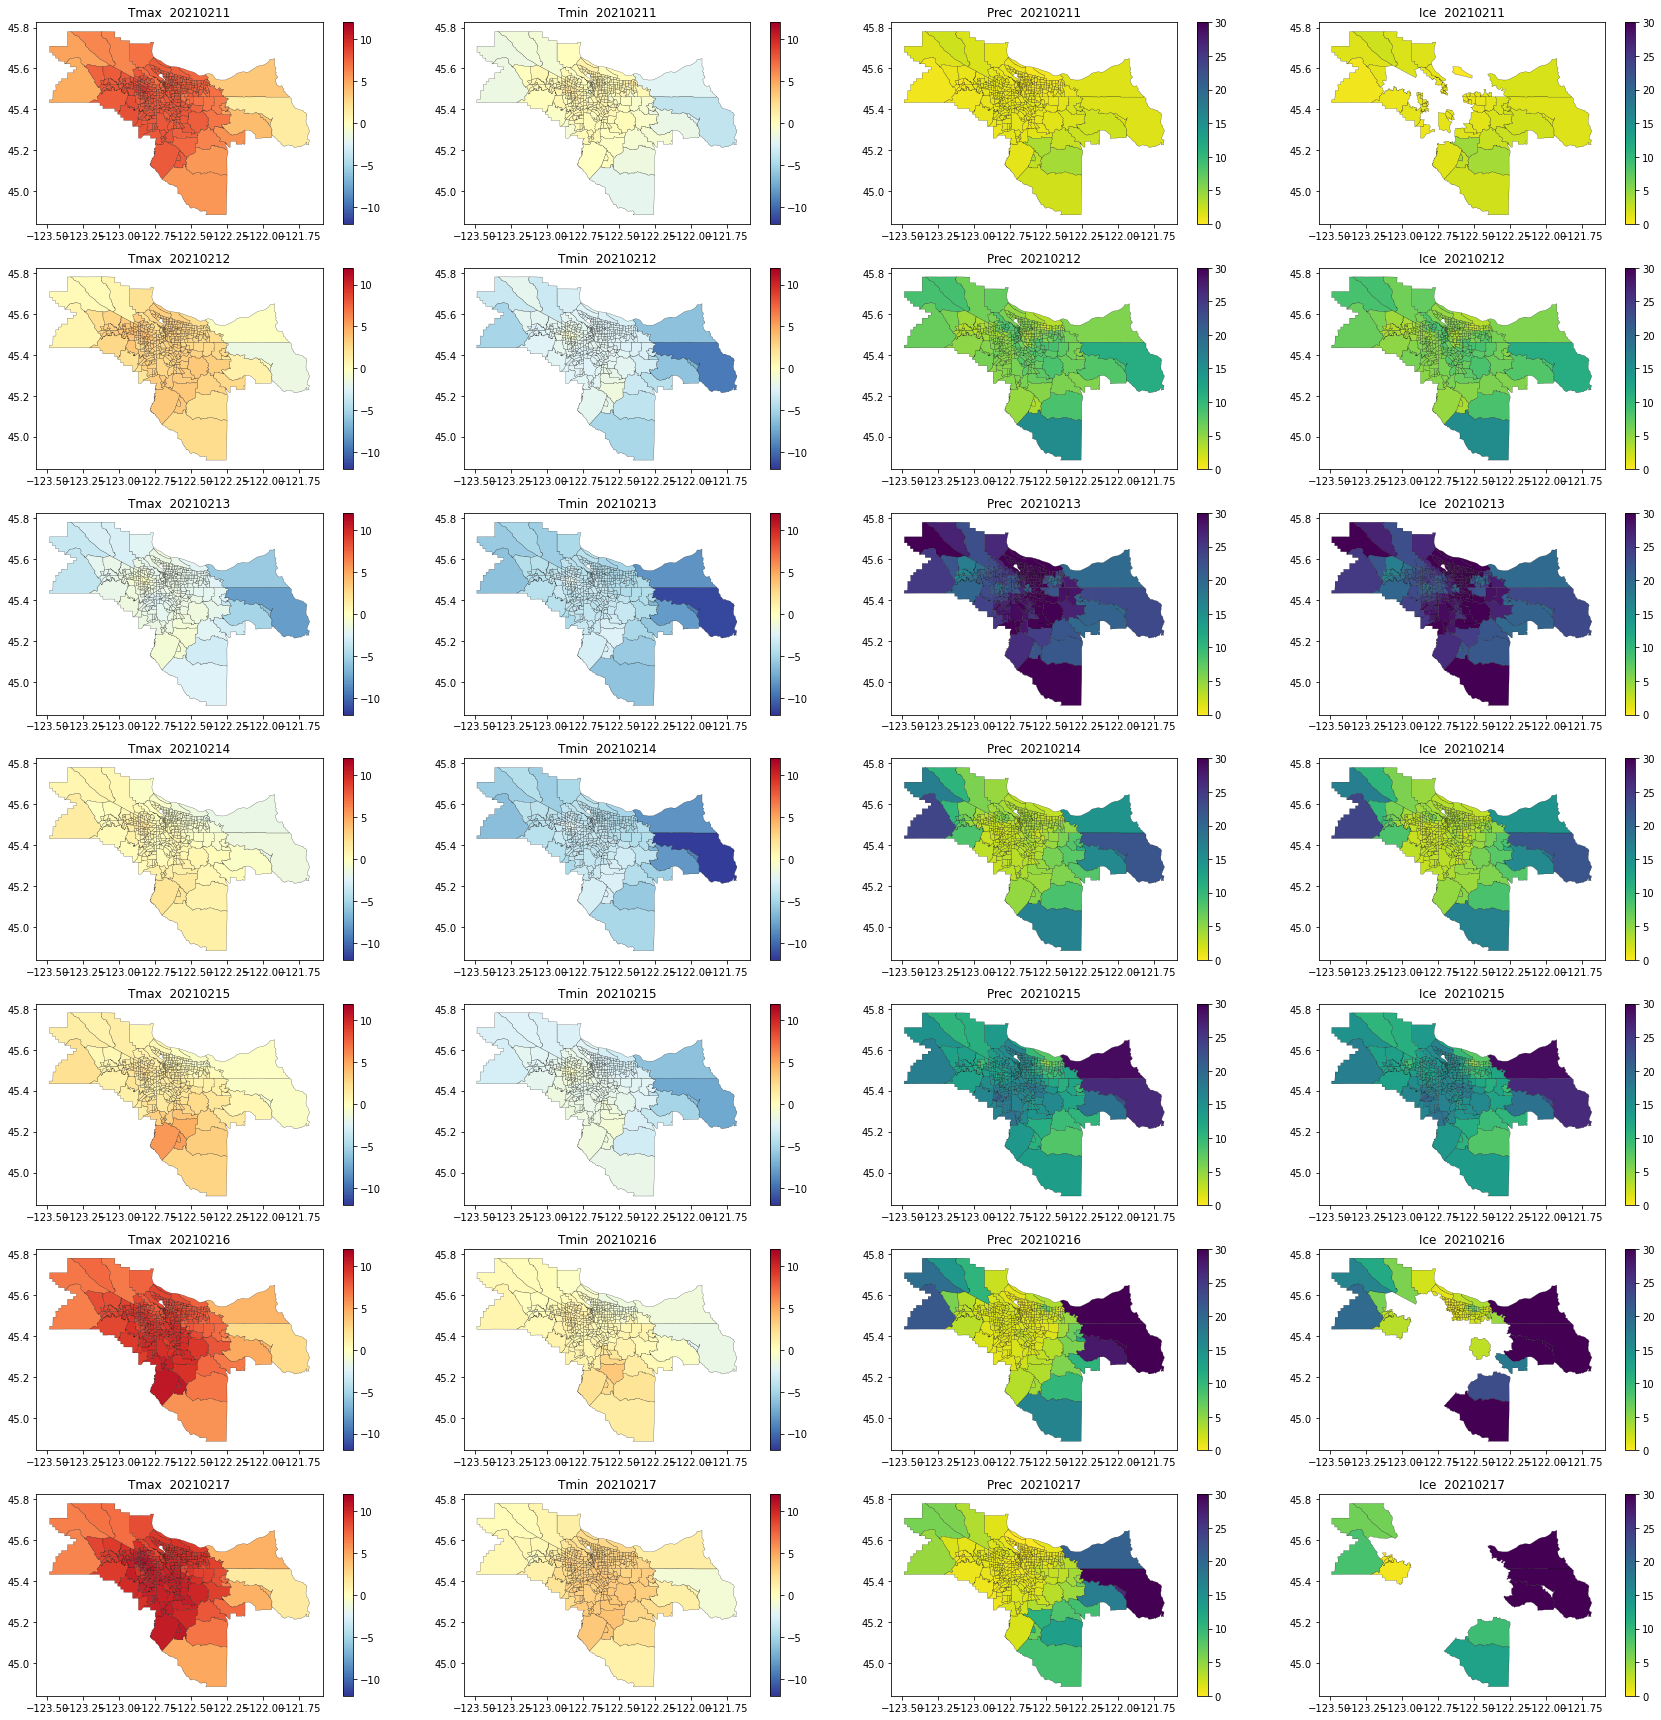

In [15]:
var_s = ['Tmax', 'Tmin', 'Prec', 'Ice']
cmap_s = ['RdYlBu_r','RdYlBu_r','viridis_r','viridis_r']
n_var = len(var_s)
da_4d = xr.concat([tmax_3d, tmin_3d, prec_3d, ice_3d], "var_s")

shp_gpd = plot_shp_p(da_4d, var_s, county_2d, shp_gpd.lat_centroid, shp_gpd.lon_centroid, cmap_s, date_s,shp_gpd)

##### Number of days with Tmin<0 for the event

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


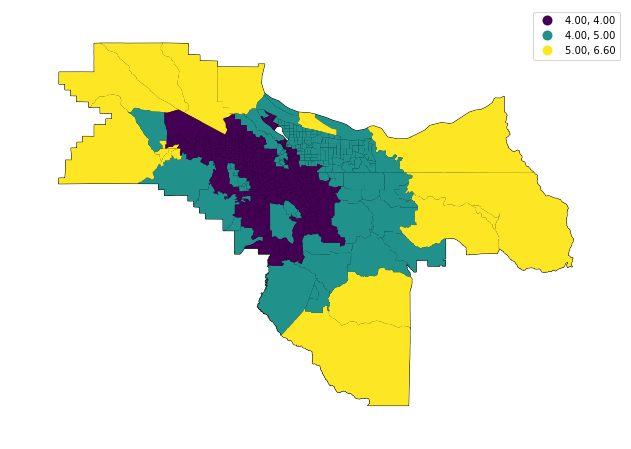

In [16]:
n_ice_3d = xr.where(tmin_3d<0, 1, 0)
n_ice_2d = n_ice_3d.sum(dim='time') 

list_1d = []

for nn in range(n_shp):
    t_mean = n_ice_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = n_ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['Nid'] = np.rint(np.asarray(list_1d))
shp_gpd['Nid'] = np.asarray(list_1d)

ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
shp_gpd.plot(ax=ax, column='Nid', legend=True, scheme="quantiles");


#### lowest Tmin over all days fo the Feb event (coldest night)

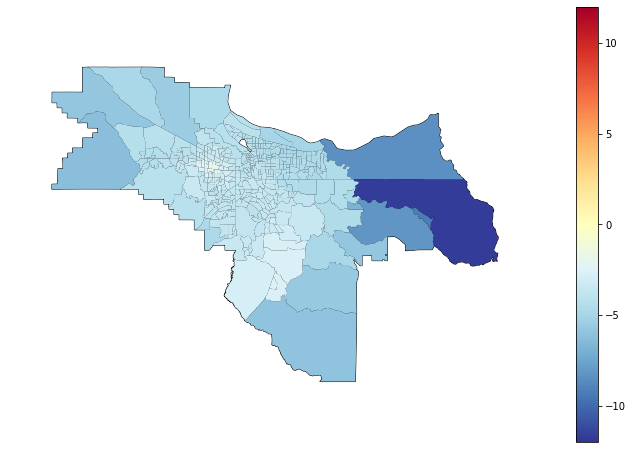

In [17]:
min_Tmin_2d = tmin_3d.min(dim='time') 
 
list_1d = []

for nn in range(n_shp):
    t_mean = min_Tmin_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = min_Tmin_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['min_Tmin'] = np.rint(np.asarray(list_1d))
shp_gpd['min_Tmin'] = np.asarray(list_1d)

ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
shp_gpd.plot(ax=ax, column='min_Tmin', cmap='RdYlBu_r', legend=True, vmin=-12, vmax=12);  

####June 2021 heatwave (June 27 - June 30)¶

In [19]:
date_st = '2021-06-27'
date_end = '2021-06-30'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

ds = xr.open_dataset(dir_prism + 'PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR

n_day = tmax_3d.shape[0]

##### daily Tmax, Tmin (No. precipitation)

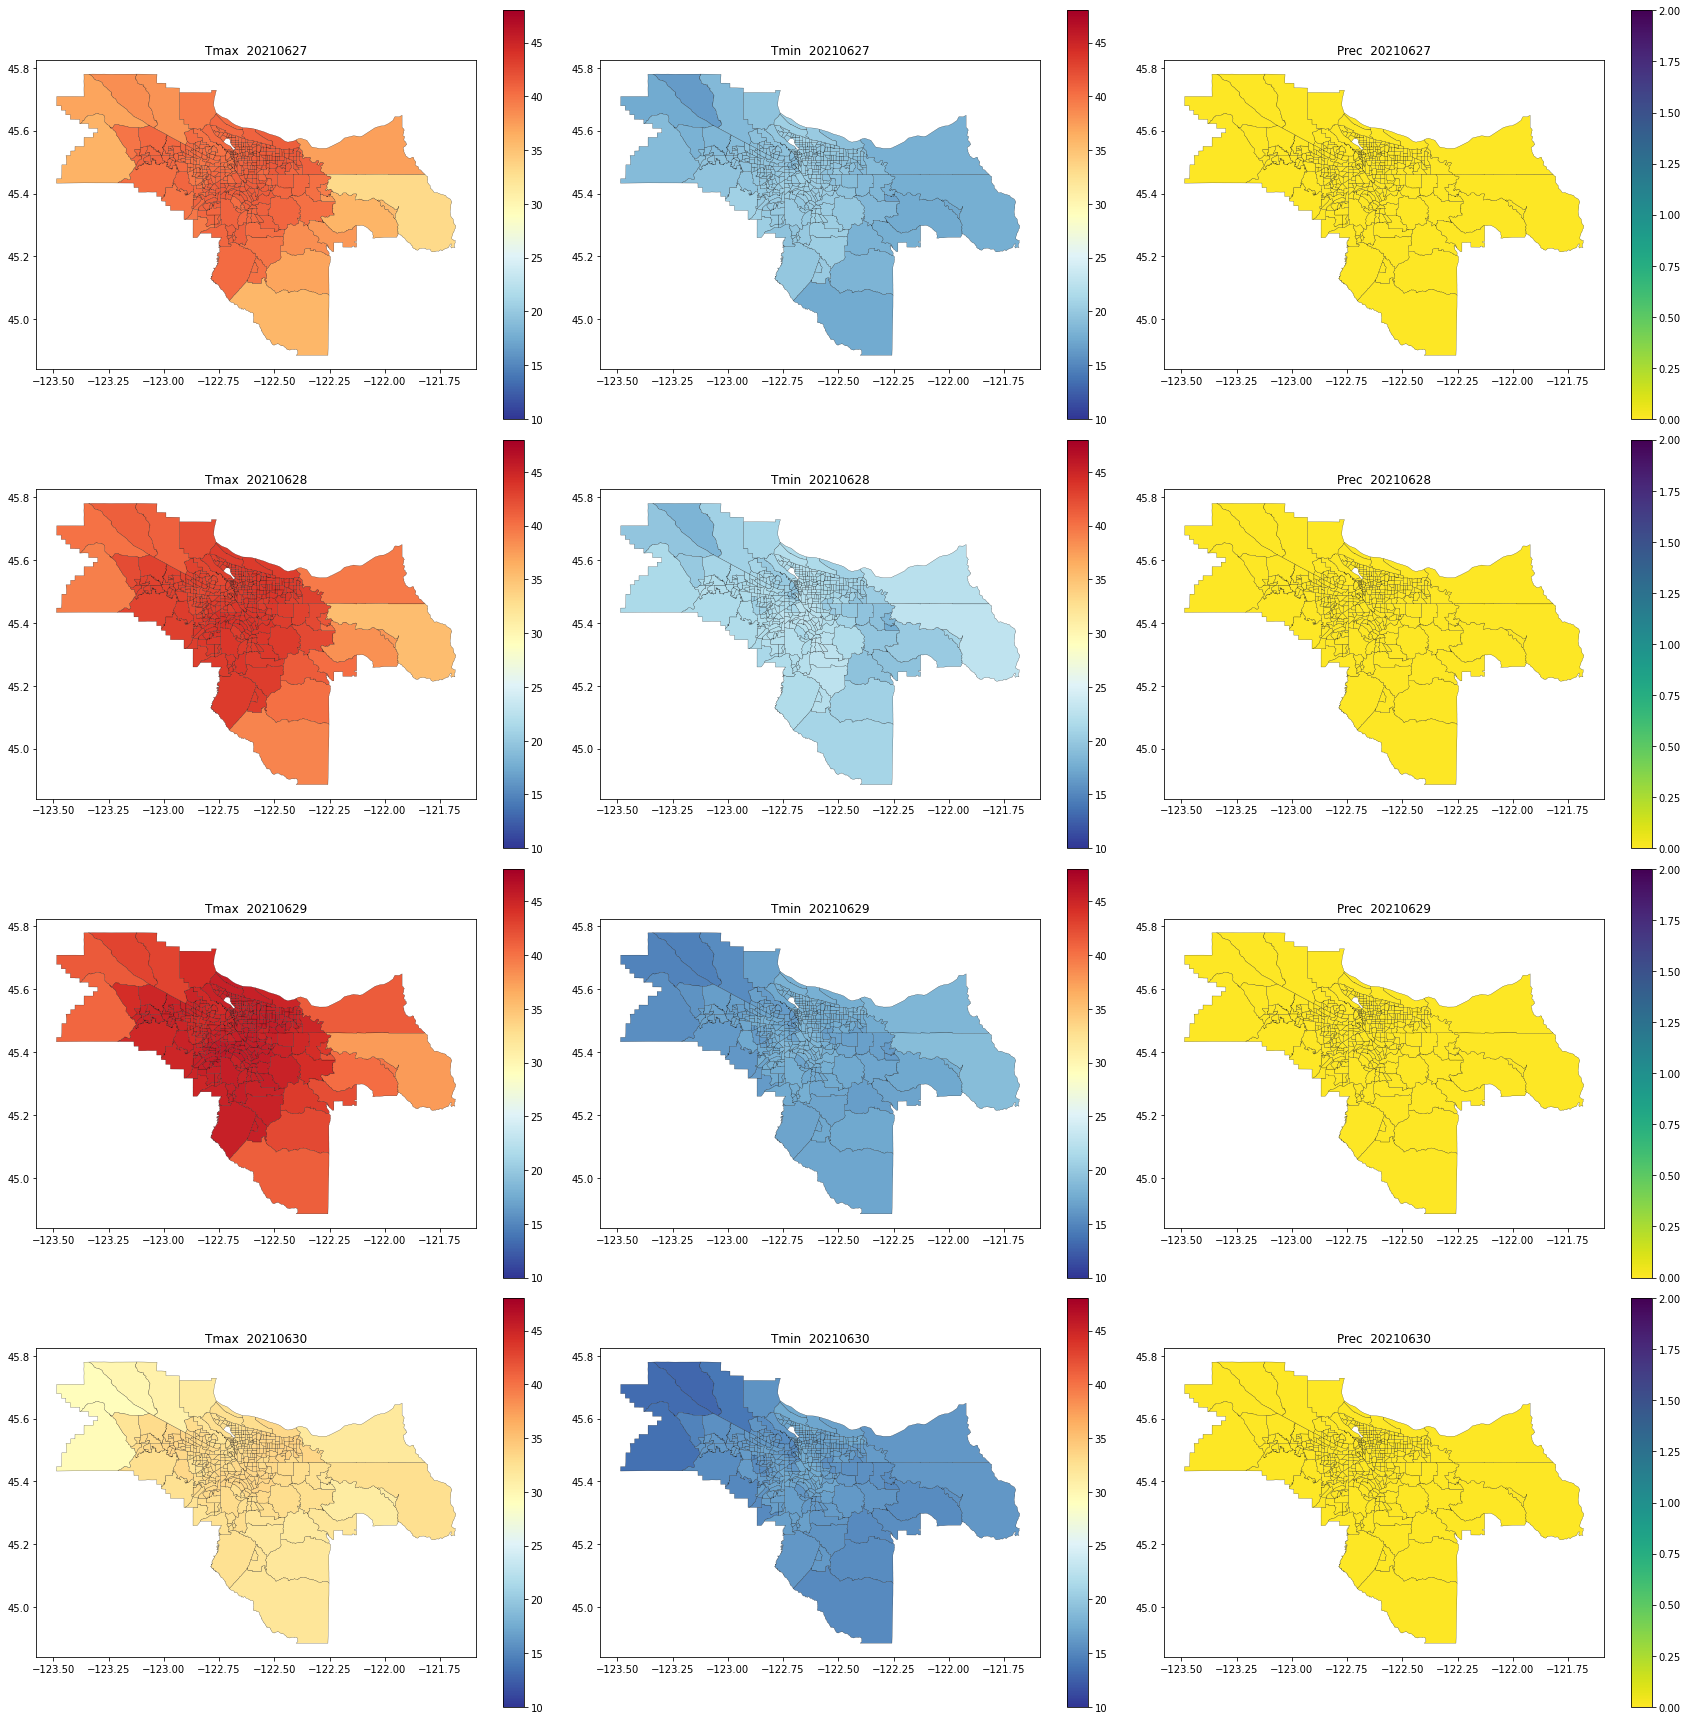

In [20]:
cmap_s = ['RdYlBu_r','RdYlBu_r','viridis_r']
var_s = ['Tmax', 'Tmin', 'Prec']
da_4d = xr.concat([tmax_3d, tmin_3d, prec_3d], "var_s")

shp_gpd = plot_shp_p(da_4d, var_s, county_2d, shp_gpd.lat_centroid, shp_gpd.lon_centroid, cmap_s, date_s,shp_gpd, 'summer')

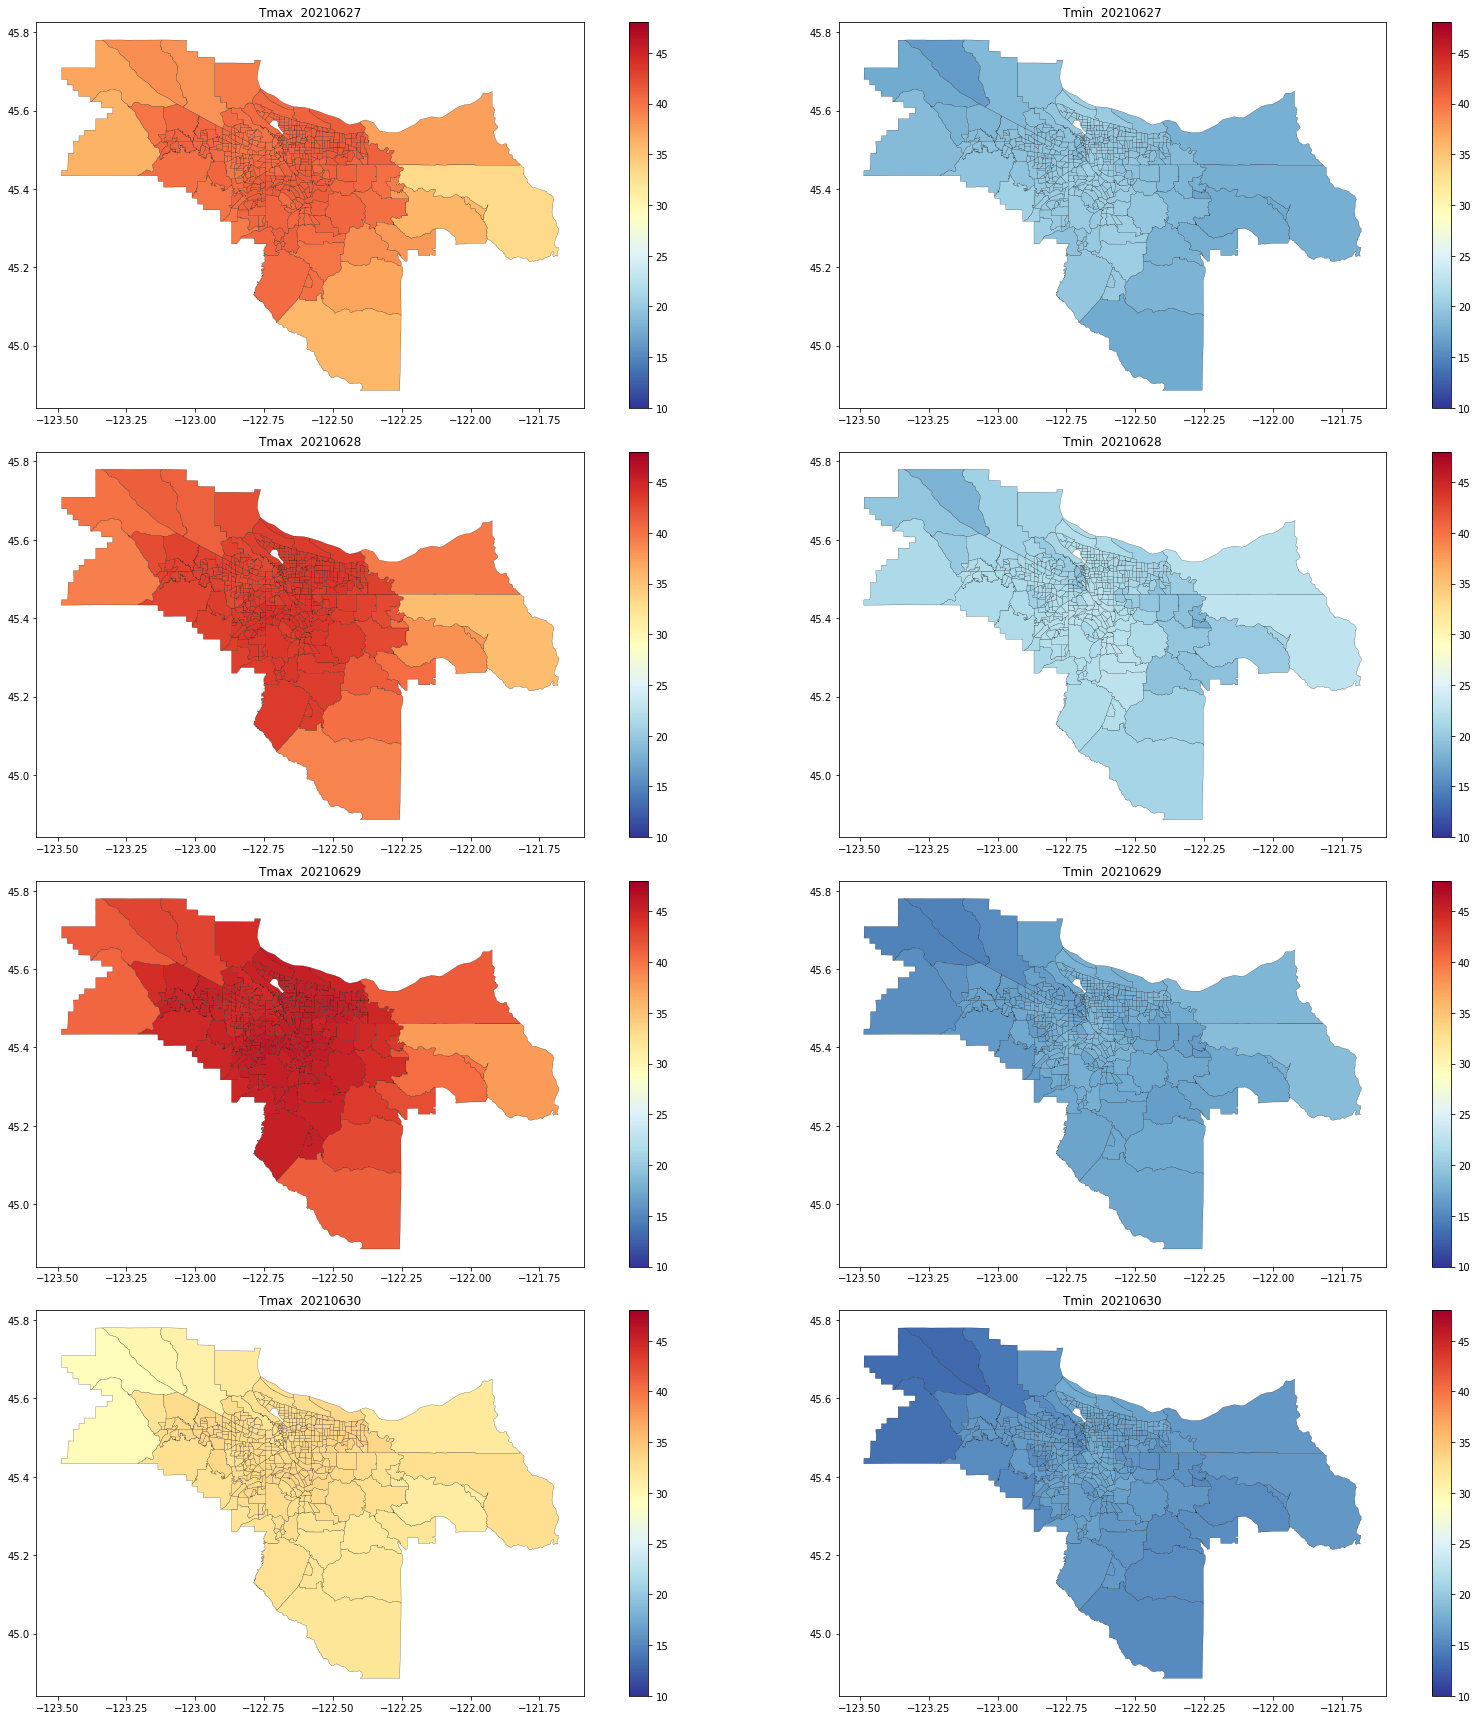

In [21]:
var_s = ['Tmax', 'Tmin']
da_4d = xr.concat([tmax_3d, tmin_3d], "var_s")
 
shp_gpd = plot_shp_p(da_4d, var_s, county_2d, shp_gpd.lat_centroid, shp_gpd.lon_centroid, cmap_s, date_s,shp_gpd, 'summer')

##### Highest Tmax (hottest day)

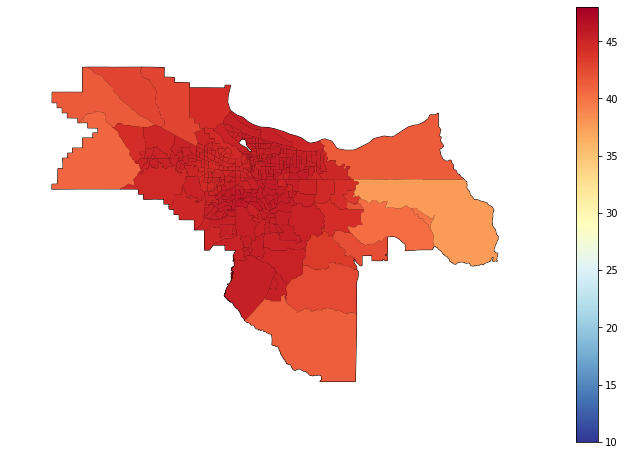

In [22]:
max_Tmax_2d = tmax_3d.max(dim='time') 
 
list_1d = []

for nn in range(n_shp):
    t_mean = max_Tmax_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = max_Tmax_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['max_Tmax'] = np.rint(np.asarray(list_1d))
shp_gpd['max_Tmax'] = np.asarray(list_1d)

ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
shp_gpd.plot(ax=ax, column='max_Tmax', cmap='RdYlBu_r', legend=True, vmin=10, vmax=48);  

##### Highest Tmin (Hottest night)

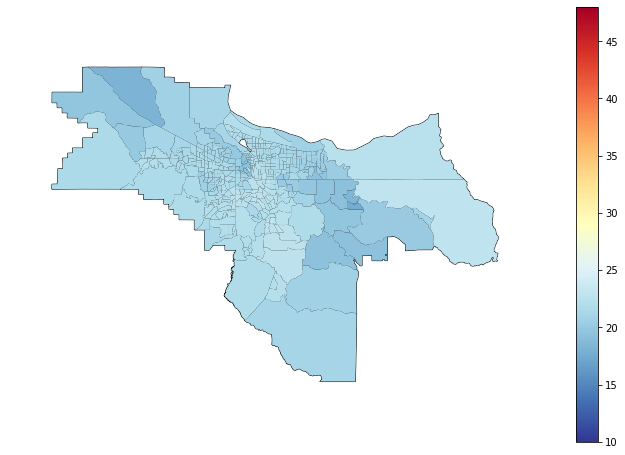

In [23]:
max_Tmin_2d = tmin_3d.max(dim='time') 
 
list_1d = []

for nn in range(n_shp):
    t_mean = max_Tmin_2d.where(county_2d==nn, other=np.nan).mean(dim=('rlat', 'rlon')).values
    if np.isnan(t_mean):
        # when there is no grid point within the shape, use the nearest grid
        lat_0 = shp_gpd.lat_centroid[nn]
        lon_0 = shp_gpd.lon_centroid[nn]
        t = max_Tmin_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
        list_1d.append(t.values)
    else:
        list_1d.append(t_mean)

### NOTE:  use numpy array
shp_gpd['max_Tmin'] = np.rint(np.asarray(list_1d))
shp_gpd['max_Tmin'] = np.asarray(list_1d)

ax = gplt.polyplot(shp_gpd, figsize=(12, 8))
shp_gpd.plot(ax=ax, column='max_Tmin', cmap='RdYlBu_r', legend=True, vmin=10, vmax=48);  